In [1]:
import ibmJupyterNotebookStyles
ibmJupyterNotebookStyles.apply_ibm_styles()

# Quantum kernel estimation for classical algorithms

In this section, we provide a brief overview of how the quantum kernel estimation (QKE) procedure can be used to enhance classical algorithms that support the precomputed kernel matrix.<sup>1</sup><sup>,</sup><sup>2</sup><sup>,</sup><sup>3</sup> Specifically, we explore the following algorithms:
<ul>
    <li>Agglomerative clustering</li>
    <li>Support vector classification</li>
    <li>Support vector regression</li>
    <li>One-class SVM</li>
    <li>Ridge regression</li>
    <li>Gaussian process regression</li>
    <li>Gaussian process classification</li>
    <li>Principal component analysis</li>
</ul>

We use the `FidelityStatevectorKernel` function from ```qiskit_machine_learning.kernels.quantum_kernel```. For classical algorithm implementation, we rely on the ```scikit-learn``` library to work through some implementation details, point out differences between the algorithms, and interpret the kernel function.

In [2]:
# Import necessary libraries

# Qiskit
from qiskit.circuit.library import ZFeatureMap, ZZFeatureMap, PauliFeatureMap
from qiskit_machine_learning.kernels import FidelityStatevectorKernel 

# scikit learn
from sklearn.cluster import AgglomerativeClustering
from sklearn import svm
from sklearn.svm import OneClassSVM
from sklearn.kernel_ridge import KernelRidge
import sklearn.metrics as metrics
from sklearn.datasets import load_digits
from sklearn.decomposition import KernelPCA
from sklearn.datasets import make_friedman2
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, Kernel, StationaryKernelMixin, NormalizedKernelMixin
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

# Visualization
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.cluster.hierarchy import dendrogram
import numpy as np

## Agglomerative clustering

Hierarchical clustering methods produce representations where the clusters at each level of the hierarchy are created by merging clusters at the next lower level. At the lowest level, each cluster contains a single observation. At the highest level, there is only one cluster containing all of the data. Strategies for hierarchical clustering can be divided into agglomerative (bottom-up) and divisive (top-down).<sup>4</sup><br> 

Agglomerative strategies start at the bottom and at each level recursively merge a selected pair of clusters into a single cluster based on the linkage criteria that determine the metric used for the merge strategy (that is, Ward, maximum or complete linkage, average linkage, or single linkage).<sup>5</sup>

### Classical approach

In [3]:
# Generate input data
X = np.array([[1, 2], [1, 4], [1, 0],
             [4, 2], [4, 4], [4, 0]])

# Define and run analysis
clustering = AgglomerativeClustering(linkage="ward",compute_distances=True).fit(X)

# Print results
print("Labels : ", clustering.labels_)


Labels :  [1 1 1 0 0 0]


### Quantum approach

In [4]:
#calculate quantum kernel
feature_map = ZZFeatureMap(feature_dimension=2,reps=2,entanglement="full")
qk = FidelityStatevectorKernel(feature_map=feature_map)

kernel_matrix = qk.evaluate

In [5]:
clustering_qke = AgglomerativeClustering(metric=kernel_matrix, \
                                     linkage="complete", \
                                     compute_distances=True).fit(X)
# Print results
print("Labels : ", clustering_qke.labels_)

Labels :  [1 1 1 0 0 0]


/Users/iuliazidaru/opt/anaconda3/envs/qml/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


### Visualization

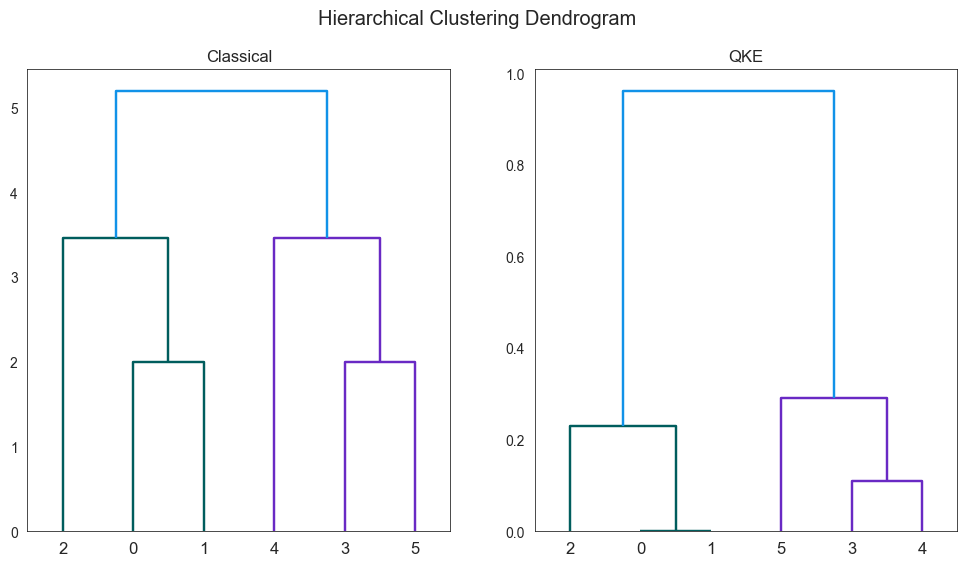

In [6]:
# Creating dendrogram visualization
# Following https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html
def plot_dendrogram(model, ax=None, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, ax=ax, **kwargs)
    
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(12,6))
fig.suptitle('Hierarchical Clustering Dendrogram')
plot_dendrogram(clustering, ax1, truncate_mode='level', p=3)
ax1.set_title("Classical")
plot_dendrogram(clustering_qke, ax2, truncate_mode='level', p=3)
ax2.set_title("QKE")
plt.show()

Both methods produce the same labels. However, the solutions are slightly different, as can be seen on dendrograms. QKE leads to denser clusters separated by longer distance.

Agglomerative clustering doesn’t have a predict stage. Therefore, for any given data set, it needs to calculate the full kernel matrix that includes all pairs of observations. In other words, the approach requires $\mathcal O({\vert T \vert}^{2})$ kernel elements estimations, where $\vert T \vert$ is the size of the input data.

## Support vector classification

Detailed information about support vector machines (SVMs) was provided in the “Classical machine learning algorithms” module. Here, we are walking through a simple data science task to demostrate the code syntax. Hyperparameter optimization for SVM with quantum kernel is described later in another notebook in this module. A more comprehensive case study with QSVC applied to a practical data set is found at the end of the module.

### Classical approach

In [7]:
# Generate input data
X = [[0, 0], [1, 1]]
y = [0, 1]

# Run classical SVC with default kernel
clf = svm.SVC()
clf.fit(X, y)

SVC()

In [8]:
# Prediction
print("Prediction value = ",clf.predict([[2., 2.]])[0])

Prediction value =  1


In [9]:
# Miscellaneous output

# get support vectors
print("support_vectors = ", clf.support_vectors_)
# get indices of support vectors
print("indices of support vectors = ",clf.support_)
# get number of support vectors for each class
print("number of support vectors for each class = ", clf.n_support_)


support_vectors =  [[0. 0.]
 [1. 1.]]
indices of support vectors =  [0 1]
number of support vectors for each class =  [1 1]


### Quantum approach

In [10]:
# Define a feature map and a quantum kernel
feature_map = ZFeatureMap(feature_dimension=2,reps=1)

#calculate quantum kernel
qk = FidelityStatevectorKernel(feature_map=feature_map)
kernel_matrix = qk.evaluate

# Fit the model
clf_qke = svm.SVC(kernel=kernel_matrix)
clf_qke.fit(X, y)

SVC(kernel=<bound method FidelityStatevectorKernel.evaluate of <qiskit_machine_learning.kernels.fidelity_statevector_kernel.FidelityStatevectorKernel object at 0x7fd612649480>>)

In [11]:
print("Prediction value = ",clf_qke.predict([[2., 2.]])[0])

Prediction value =  1


In [12]:
# get support vectors
print("support_vectors = ", clf_qke.support_vectors_)
# get indices of support vectors
print("indices of support vectors = ",clf_qke.support_)
# get number of support vectors for each class
print("number of support vectors for each class = ", clf_qke.n_support_)

support_vectors =  []
indices of support vectors =  [0 1]
number of support vectors for each class =  [1 1]


### Visualization

Let’s plot decision boundaries using the `mlxtend` library.

In [13]:
# Please, note, this takes a long time to complete.
#from mlxtend.plotting import plot_decision_regions
#import matplotlib.gridspec as gridspec
#gs = gridspec.GridSpec(1, 2)
#fig = plt.figure(figsize=(16, 8))

#fig1 = fig.add_subplot(gs[0, 0])
#fig1 = plot_decision_regions(np.array(X), np.array(y), clf=clf, legend=2)
#plt.title("Classical")

#fig2 = fig.add_subplot(gs[0, 1])
#fig2 = plot_decision_regions(np.array(X), np.array(y), clf=clf_qke, legend=2)
#plt.title("QKE")
#plt.show()

![](figs/decision_boundaries_classical_qke.png)

In this simple example, both decision boundaries calculated based on the classical kernel and the quantum kernel are exactly the same.<br>

SVM requires $\mathcal O({\vert T \vert}^{2})$ quantum kernel element estimations, where $\vert T \vert$ is the size of the input data for training. It requires $\mathcal O({\vert T \vert}{\vert S \vert})$ quantum kernel element estimations, where $\vert S \vert$ is the size of the data for deployment.

## Support vector regression

As with QSVC, we walk through a simple data science task to demonstrate the code syntax for QSVR. QSVR will be discussed in more detail in the “Signature learning asset for forecasting” notebook in the “Industry problem example” module.

In [14]:
# Generate input data
X = [[0, 0], [2, 2]]
y = [0.5, 2.5]

### Classical approach

In [15]:
# Define analysis and fit
regr = svm.SVR()
regr.fit(X, y)
print("Classical prediction = ",regr.predict([[1, 1]])[0])

Classical prediction =  1.5


### Quantum approach

In [16]:
# Define quantum feature map and kernel
feature_map = ZFeatureMap(feature_dimension=2,reps=1)

#calculate quantum kernel
qk = FidelityStatevectorKernel(feature_map=feature_map)
kernel_matrix = qk.evaluate

# Run classical SVR with quantum kernel
regr_qke = svm.SVR(kernel=kernel_matrix)
regr_qke.fit(X, y)
print("QKE prediction = ",regr_qke.predict([[1, 1]])[0])

QKE prediction =  1.5


### Visualization

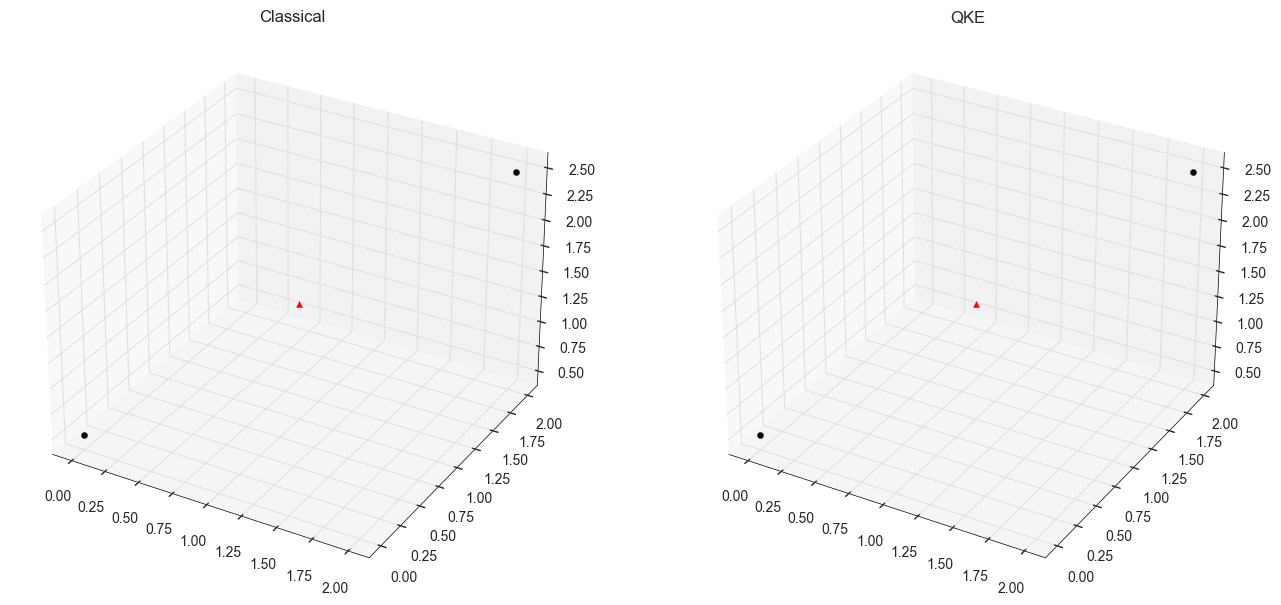

In [17]:
# We will use 3d scatterplots to compare results side-by-side
gs = gridspec.GridSpec(1, 2)
fig = plt.figure(figsize=(16, 8))

fig1 = fig.add_subplot(gs[0, 0],projection='3d')
fig1.scatter([X[i][0] for i in range(len(X))], \
           [X[i][1] for i in range(len(X))], \
           y, marker='o', c = 'black', depthshade=False)
fig1.scatter(1,1,regr.predict([[1, 1]])[0],marker='^', c = 'red', depthshade=False)
plt.title("Classical")

fig2 = fig.add_subplot(gs[0, 1],projection='3d')
fig2.scatter([X[i][0] for i in range(len(X))], \
           [X[i][1] for i in range(len(X))], \
           y, marker='o', c = 'black', depthshade=False)
fig2.scatter(1,1,regr_qke.predict([[1, 1]])[0],marker='^', c = 'red', depthshade=False)
plt.title("QKE")
plt.show()

Predictions from both kernels, shown by the red triangles, matched. <br>

SVM requires $\mathcal O({\vert T \vert}^{2})$ quantum kernel element estimations, where $\vert T \vert$ is the size of the input data for training. It requires $\mathcal O({\vert T \vert}{\vert S \vert})$ quantum kernel element estimations, where $\vert S \vert$ is the size of the data for deployment.<br>

So far, we have been able to pass quantum kernels as executable to respective algorithms in `scikit-learn`. Below, we see some examples where modifications are required.

## One-class SVM

One-class SVM can be used for unsupervised learning and outlier detection.<sup>6</sup><sup>,</sup><sup>7</sup>

It requires the choice of a kernel and a scalar parameter to define a frontier. However, in order to avoid overfitting, we need to fine-tune its hyperparameter, $nu$. The $nu$ parameter, also known as the margin of the one-class SVM, corresponds to the probability of finding a new but regular observation outside the frontier.


### Classical approach

In [18]:
# Generate input data
X = [[0], [0.44], [0.45], [0.46], [1]]

# Define OneClassSVM
clf = OneClassSVM(gamma='auto').fit(X)
print(clf.predict(X))
print(clf.score_samples(X))

[-1  1  1  1 -1]
[1.77987316 2.05479873 2.05560497 2.05615569 1.73328509]


### Quantum approach

In [19]:
# Define the feature map and quantum kernel
feature_map = ZFeatureMap(feature_dimension=2,reps=1)#ZZFeatureMap(feature_dimension=2,reps=1,entanglement="full")

# Calculate quantum kernel
qk = FidelityStatevectorKernel(feature_map=feature_map)
kernel_matrix = qk.evaluate

# Initialize OneClassSVM with quantum kernel
clf_qke = OneClassSVM(kernel = kernel_matrix,gamma='auto').fit(X)
print(clf_qke.predict(X))
print(clf_qke.score_samples(X))

[-1  1  1  1 -1]
[1.70121437 2.0364168  2.03755305 2.03837429 1.65084719]


Similar to SVM, it requires $\mathcal O({\vert T \vert}^{2})$ quantum kernel element estimations, where $\vert T \vert$ is the size of the input data for training. It requires $\mathcal O({\vert T \vert}{\vert S \vert})$ quantum kernel element estimations, where $\vert S \vert$ is the size of the data for deployment.

## Ridge regression

Ridge regression shrinks the regression coefficients by imposing a penalty on their size. The ridge coefficients minimize a penalized residual sum of squares:<br>
$ \hat{\beta}^{ridge} = \underset{\beta}{\arg\!\min} \left\{ \sum\limits_{i=1}^{N} \left( y_{i}-{\beta}_{0}-\sum\limits_{j=1}^{p} {x_{ij}{\beta}_j} \right) ^{2} + \lambda \sum\limits_{j=1}^{p} {\beta}_{j}^{2} \right\} $

In the matrix form<sup>3</sup>:

$ \hat{\boldsymbol{\beta}}^{ridge} = \underset{\beta}{\arg\!\min} \left\{(\boldsymbol{y}-\boldsymbol{X}\boldsymbol{\beta})^{T}(\boldsymbol{y}-\boldsymbol{X}\boldsymbol{\beta})+\lambda\lVert{\boldsymbol{\beta}}\rVert^{2}\right\}=\boldsymbol{X}^{T}(\boldsymbol{X}\boldsymbol{X}^{T}+\lambda\boldsymbol{I}_{N})^{-1}\boldsymbol{y}$<br>

Now, we introduce kernel matrix (inner product or Gram matrix): $\boldsymbol{K}=\boldsymbol{X}\boldsymbol{X}^{T} $ and dual variables $\boldsymbol{\alpha}=(\boldsymbol{K}+\lambda\boldsymbol{I}_{N})\boldsymbol{y}$ so that

$\hat{\boldsymbol{\beta}}^{ridge}=\boldsymbol{X}^{T}\boldsymbol{\alpha}$<br>

When we compute the prediction for a new observation, we get:

$\hat{f}(\boldsymbol{x})=\boldsymbol{\beta}^{T}\boldsymbol{x}=\sum\limits_{i=1}^{N}\alpha_{i}\kappa(\boldsymbol{x},\boldsymbol{x}_{i})$

In [20]:
# Generate input data
n_samples, n_features = 10, 5
rng = np.random.RandomState(0)
y = rng.randn(n_samples)
X_rr = rng.randn(n_samples, n_features)

### Classical approach

In [21]:
# Define and fit the model
clf = KernelRidge(alpha=1.0)
clf.fit(X_rr, y)
print("coefficient 0: ",clf.coef0)
print("dual coef:", clf.dual_coef_)

# Build prediction
y_pred = clf.predict(X_rr)

# Various performance metrics
explained_variance=metrics.explained_variance_score(y, y_pred)
mean_absolute_error=metrics.mean_absolute_error(y, y_pred) 
mse=metrics.mean_squared_error(y, y_pred) 
median_absolute_error=metrics.median_absolute_error(y, y_pred)
r2=metrics.r2_score(y, y_pred)

print('explained_variance: ', round(explained_variance,4))    
print('r2: ', round(r2,4))
print('MAE: ', round(mean_absolute_error,4))
print('MSE: ', round(mse,4))
print('RMSE: ', round(np.sqrt(mse),4))

coefficient 0:  1
dual coef: [ 1.53839505  0.20049053 -0.33063188  1.15477888  1.28601901 -0.49046154
  0.46714476  0.77765325 -0.78298407  0.82155474]
explained_variance:  0.3905
r2:  0.1601
MAE:  0.785
MSE:  0.7855
RMSE:  0.8863


### Quantum approach

Note that in order to use the kernel function estimated on a quantum computer with `KernelRidge`, we need to overwrite the kernel function as shown here:

In [22]:
# Define the feature map and quantum kernel
feature_map = ZFeatureMap(feature_dimension=2,reps=1)#ZZFeatureMap(feature_dimension=2,reps=1,entanglement="full")

#calculate quantum kernel
qk = FidelityStatevectorKernel(feature_map=feature_map)
kernel_matrix = qk.evaluate

# Initialize OneClassSVM with quantum kernel
clf_qke = OneClassSVM(kernel = kernel_matrix,gamma='auto').fit(X)
print(clf_qke.predict(X))
print(clf_qke.score_samples(X))

[-1  1  1  1 -1]
[1.70121437 2.0364168  2.03755305 2.03837429 1.65084719]


In [23]:
# Define quantum feature map and kernel matrix
feature_map = ZZFeatureMap(feature_dimension=5,reps=1,entanglement="full")
qk = FidelityStatevectorKernel(feature_map=feature_map)
kernel_matrix = qk.evaluate

# Need to overwrite standard kernel function as follows to comply with Ridge Regression.
def kernel_tuple_inputs(x_vec: np.ndarray, y_vec: np.ndarray):
    km = kernel_matrix(tuple(locals().values()))
    return km[0,1]

# Run classical kernel ridge regression with quantum kernel
clf_qke = KernelRidge(alpha=1.0, kernel=kernel_tuple_inputs).fit(X_rr, y)
print("dual coef:", clf_qke.dual_coef_)

# Build prediction
y_pred = clf_qke.predict(X_rr)

# Various performance metrics
explained_variance=metrics.explained_variance_score(y, y_pred)
mean_absolute_error=metrics.mean_absolute_error(y, y_pred) 
mse=metrics.mean_squared_error(y, y_pred) 
median_absolute_error=metrics.median_absolute_error(y, y_pred)
r2=metrics.r2_score(y, y_pred)

print('explained_variance: ', round(explained_variance,4))    
print('r2: ', round(r2,4))
print('MAE: ', round(mean_absolute_error,4))
print('MSE: ', round(mse,4))
print('RMSE: ', round(np.sqrt(mse),4))

dual coef: [ 0.85855672  0.1218116   0.45416889  1.04559595  0.87451005 -0.51898891
  0.39698428 -0.11247139 -0.09407649  0.15970824]
explained_variance:  0.7567
r2:  0.6482
MAE:  0.4637
MSE:  0.329
RMSE:  0.5736


The model with the quantum kernel has a higher $r2$ value. However, this is a tiny data set and we didn’t perform any parameter tuning.

This method requires $\mathcal O({\vert T \vert}^{2})$ quantum kernel element estimations, where $\vert T \vert$ is the size of the input data for training. It requires $\mathcal O({\vert T \vert}{\vert S \vert})$ quantum kernel element estimations, where $\vert S \vert$ is the size of the data for deployment.

## Gaussian process regression

Gaussian processes (GP) are used as the basis for non-parametric machine learning algorithms for classification and regression.<sup>8</sup><sup>,</sup><sup>9</sup><sup>,</sup><sup>10</sup> They are viewed as a generalization of the Gaussian probability distribution. Similar to SVM, one can think of GPs as a type of kernel model. They are capable of predicting highly calibrated class membership probabilities, although the choice and configuration of the kernel used at the heart of the method can be challenging. The most important hyperparameter is the kernel controlled via the “kernel” argument.

`Scikit-learn` provides the following kernels:

In [24]:
from sklearn.gaussian_process import kernels
dir(kernels)

['ABCMeta',
 'CompoundKernel',
 'ConstantKernel',
 'ConvergenceWarning',
 'DotProduct',
 'ExpSineSquared',
 'Exponentiation',
 'GenericKernelMixin',
 'Hyperparameter',
 'Kernel',
 'KernelOperator',
 'Matern',
 'NormalizedKernelMixin',
 'PairwiseKernel',
 'Product',
 'RBF',
 'RationalQuadratic',
 'StationaryKernelMixin',
 'Sum',
 'WhiteKernel',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_approx_fprime',
 '_check_length_scale',
 '_num_samples',
 'abstractmethod',
 'cdist',
 'clone',
 'gamma',
 'kv',
 'math',
 'namedtuple',
 'np',
 'pairwise_kernels',
 'pdist',
 'signature',
 'squareform',
 'warnings']

You can use one or a superposition of kernels (for example, `DotProduct()` + `WhiteKernel()`).

In [25]:
# Generating the data
X, y = make_friedman2(n_samples=500, noise=0, random_state=0)


### Classical approach

In [26]:
# Define the kernel and GP
kernel = DotProduct() + WhiteKernel()
gpr = GaussianProcessRegressor(kernel=kernel, random_state=0).fit(X, y)
print(gpr.score(X, y))
print(gpr.predict(X[:2,:], return_std=True))

0.3680293861017315
(array([653.08792288, 592.16905327]), array([316.68016218, 316.65121679]))


/Users/iuliazidaru/opt/anaconda3/envs/qml/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/iuliazidaru/opt/anaconda3/envs/qml/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


### Quantum approach

Note that in a quantum approach, we need to define a separate class that inherits from the base classes, then create an instance of it.

In [27]:
# Define the feature map and quantum kernel
feature_map = ZZFeatureMap(feature_dimension=X.shape[1],reps=1,entanglement="full")
qk = FidelityStatevectorKernel(feature_map=feature_map)

kernel_matrix = qk.evaluate

# Create new class for the quantum kernel
class GP_quantumkernel(StationaryKernelMixin, NormalizedKernelMixin, Kernel):
    def __init__(self):
        pass
    
    def __call__(self, X, Y=None, eval_gradient=False):
        return kernel_matrix(X,Y)
    
# Create an instance on the class
quantumKM = GP_quantumkernel()

# Define GP and fit the data
gpr = GaussianProcessRegressor(kernel=quantumKM, random_state=0).fit(X, y)

# Score and predict
print(gpr.score(X, y))
print(gpr.predict(X[:2,:], return_std=True))

0.5269935472759023
(array([596.56958008, 726.00390625]), array([6.47352132e-06, 7.35006479e-06]))


0.5269947797209305
(array([596.57324219, 726.01025391]), array([6.47358992e-06, 7.35020073e-06]))

## Gaussian process classification

Similar to GPs for regression, they can be used for classification as follows:

In [28]:
# Load input data
X, y = load_breast_cancer(return_X_y=True)
X = X[:,:10].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

### Classical approach

In [29]:
# Define the kernel, GP classifier, build predictions
kernel = DotProduct() + WhiteKernel()
gpc = GaussianProcessClassifier(kernel=kernel, random_state=0).fit(X_train, y_train)
print("Train score = ", gpc.score(X_train, y_train))
print(gpc.predict(X_train))
print("Test score = ", gpc.score(X_test, y_test))
print(gpc.predict(X_test))

Train score =  0.9178403755868545
[1 1 0 1 0 1 1 1 0 1 1 1 0 1 1 1 0 0 1 1 0 1 0 0 0 1 1 1 1 1 1 0 1 1 1 1 0
 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1 0 0 1 1 0 1 1 0 0 0 1 1 1 0 1 1 1 1 1 0 1 0
 1 0 1 0 1 1 1 1 1 1 0 1 0 1 1 1 0 1 1 1 0 1 1 0 0 1 0 1 1 1 0 1 0 0 1 1 1
 0 1 0 1 0 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1
 1 1 0 0 1 0 0 1 1 1 1 1 1 0 1 1 1 1 0 0 0 1 1 1 1 0 0 1 1 1 1 1 1 1 0 1 0
 1 1 0 0 1 1 1 0 0 1 1 1 0 1 0 0 1 1 1 0 1 0 0 1 0 1 1 1 0 1 1 1 0 1 1 1 0
 1 1 1 0 1 0 1 0 0 0 0 1 1 1 1 1 0 0 1 1 1 1 0 1 1 0 1 1 0 0 0 0 1 1 0 1 1
 1 1 1 1 1 1 1 1 0 0 0 1 0 0 1 1 1 1 1 1 0 1 1 1 0 1 1 1 0 1 0 1 0 0 1 1 1
 1 1 0 0 0 1 1 0 0 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 0 1 1 1 1 0 1 0
 1 0 1 0 1 0 1 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 0 1 0 1 1 1 1 1
 0 0 1 1 0 1 1 0 0 0 0 1 0 0 0 1 0 1 0 1 1 0 0 0 0 1 1 1 1 0 1 1 0 1 1 0 0
 0 1 1 1 0 1 1 0 1 1 1 1 1 0 0 0 1 1 1]
Test score =  0.9090909090909091
[0 1 1 1 1 1 1 1 1 1 0 0 1 0 1 0 1 0 0 0 1 0 1 1 0 1 1 0 1 0 1 0 1 0

/Users/iuliazidaru/opt/anaconda3/envs/qml/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


### Quantum approach

In [30]:
# Define feature map and kernel
feature_map = PauliFeatureMap(feature_dimension=X_train.shape[1],reps=1,paulis=['Z','ZZ'])
qk = FidelityStatevectorKernel(feature_map=feature_map)
kernel_matrix = qk.evaluate

# Create a new class for the kernel
class GP_quantumkernel(StationaryKernelMixin, NormalizedKernelMixin, Kernel):
    def __init__(self):
        pass
    
    def __call__(self, X, Y=None, eval_gradient=False):
        return kernel_matrix(X,Y)

# Create new instance of the class and fit the data
quantumKM = GP_quantumkernel()  
gpc_qke = GaussianProcessClassifier(kernel=quantumKM, random_state=0).fit(X_train, y_train)

# Print output
print("Train score = ", gpc_qke.score(X_train, y_train))
print(gpc_qke.predict(X_train))
print("Test score = ", gpc_qke.score(X_test, y_test))
print(gpc_qke.predict(X_test))

Train score =  1.0
[1 1 0 1 0 1 1 1 1 1 1 1 0 1 0 1 0 0 1 1 0 1 0 0 0 1 1 1 1 1 1 0 1 1 1 1 0
 0 1 1 0 1 1 1 1 0 1 1 0 0 1 1 0 0 1 1 0 1 1 0 0 0 1 1 1 0 1 1 1 1 1 0 1 0
 1 0 1 0 1 0 1 1 1 1 0 1 0 1 1 1 0 1 1 1 0 1 1 0 0 1 0 1 0 1 0 0 0 0 1 0 1
 0 1 0 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 0 1 0 1 1
 0 1 0 0 1 0 0 1 1 0 1 1 1 0 1 1 1 1 1 0 0 1 1 1 1 0 0 1 1 1 1 0 1 1 0 1 1
 0 1 0 1 1 1 1 0 0 0 0 1 0 1 0 0 1 1 1 1 1 0 1 1 0 1 1 0 0 1 1 1 0 0 1 1 0
 1 1 1 0 1 0 1 0 0 0 0 1 1 1 1 0 0 1 1 1 1 1 0 1 1 0 1 1 0 0 0 0 1 1 0 1 1
 1 0 0 1 1 1 1 1 0 0 0 1 0 0 1 1 1 1 1 1 0 1 1 1 1 1 1 0 0 1 0 1 0 0 1 1 1
 1 1 0 0 0 1 1 0 0 1 1 0 1 0 0 1 0 1 1 1 1 1 1 1 0 0 1 1 1 0 1 1 1 1 0 1 0
 0 0 1 0 1 0 1 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1
 0 0 0 1 0 1 1 0 0 0 0 1 0 0 0 1 0 1 0 1 1 0 0 1 0 1 1 1 1 0 1 1 0 1 1 1 0
 0 1 1 1 0 1 1 0 1 1 1 1 1 0 0 0 1 1 1]
Test score =  0.6293706293706294
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1

As can be seen from the result, GP with quantum kernel overfits. This is an exercise for learners to identify quantum kernels that can work better with this data set.

## Kernel principal component analysis

Kernel PCA expands the scope of PCA by nonlinearly transforming the features, then applying PCA in the transformed feature space.<sup>4</sup> The principal components, variables $\boldsymbol{Z}$ of a data matrix $\boldsymbol{X}$, are computed from the inner-product (Gram) matrix $\boldsymbol{K}=\boldsymbol{X}\boldsymbol{X}^{T}$. In other words, kernel PCA achieves nonlinear dimensionality reduction through the use of kernels.

In [31]:
# Generate the data
X, _ = load_digits(return_X_y=True)
X = X[:500,:10].copy()
print("shape of X: ", X.shape)

shape of X:  (500, 10)


### Classical approach

In [32]:
# Define the transformer and apply to the input data.
transformer = KernelPCA(n_components=7, kernel='rbf')
X_transformed = transformer.fit_transform(X)

print("shape of transformed X: ", X_transformed.shape)

shape of transformed X:  (500, 7)


### Quantum approach

In [33]:
# Define kernel and feature map
# Note: in this case we calculate the values of the kernel matrix explicitly 
# instead of passing it as an executable method
# In addition, we also need to "center" the kernel.
feature_map = ZZFeatureMap(feature_dimension=X.shape[1],reps=1,entanglement="full")
qk = FidelityStatevectorKernel(feature_map=feature_map)
kernel_matrix_qk = qk.evaluate(X)

In [34]:
# Centering the kernel according to John Shawe-Taylor, Nello Cristianini, 
# Kernel Methods for Pattern Analysis, 2004.

ell = kernel_matrix_qk.shape[1]
D = np.sum(kernel_matrix_qk,axis=0)/ell
E = np.sum(D)/ell
J = np.ones((ell,1))*D
kernel_matrix_qk_centered = kernel_matrix_qk - J - J.T + E * np.ones((ell,ell))

In [35]:
# Passing quantum kernel to KernelPCA
transformer_qk = KernelPCA(n_components=7, kernel="precomputed")
X_transformed_qk = transformer_qk.fit_transform(kernel_matrix_qk_centered)

In [36]:
# Printing out eigenvalues for quantum and classical algorithms.
print("classical", transformer.eigenvalues_,"\nqke", transformer_qk.eigenvalues_)

classical [16.88973427 15.15719383 12.57758419  9.60100814  8.02516403  7.72170351
  7.4506573 ] 
qke [11.00906861  9.79512827  8.41678067  7.61506175  6.76300096  6.44669753
  5.40546259]


Both approaches allowed us to reduce the dimensionality of the original problem from $10$ to $7$ features in this small example. The number of features is constrained by the number of qubits available on the quantum hardware and depends on the feature map selected. Generally, $1$ feature requires $1$ qubit. This may be a limitation for practical data sets with hundreds or thousands of features.

## References

1. <a id='QQKML'></a>“Quantum Kernel Machine Learning.” *Qiskit*. https://qiskit.org/documentation/machine-learning/tutorials/03_quantum_kernel.html.

2. <a id='ShaweTaylor'></a>John Shawe-Taylor and Nello Cristianini. *Kernel Methods for Pattern Analysis*. Cambridge, UK: Cambridge University Press, 2000.

3. <a id='murphy-ml'></a>Kevin P. Murphy. *Machine Learning: A Probabilistic Perspective*. Cambridge, MA: The MIT Press, 2012.

4. <a id='HastieTibshiraniFriedmanESL'></a>Trevor Hastie, Robert Tibshirani, and Jerome Friedman. *The Elements of Statistical Learning: Data Mining, Inference, and Prediction,* 2nd ed. New York: Springer, 2009.

5. <a id='sklearn-hierarchical'></a>“Hierarchical Clustering.” *Scikit-learn*. https://scikit-learn.org/stable/modules/clustering.html#hierarchical-clustering

6. <a id='Scholkopf2001'></a>Bernhard Schölkopf et al. “Estimating the Support of a High-Dimensional Distribution.” *Neural Computation*, vol. 13, no. 7 (2001): 1443–1471.

7. <a id='sklearn-outlier'></a>“Novelty and Outlier Detection.” *Scikit-learn*. https://scikit-learn.org/stable/modules/outlier_detection.html#outlier-detection.

8. <a id='Brownlee2020'></a>Jason Brownlee “Gaussian Processes for Classification With Python.” *Machine Learning Mastery*. October 2, 2020. https://machinelearningmastery.com/gaussian-processes-for-classification-with-python/.

9. <a id='Gortler2019'></a>Jochen Görtler, Rebecca Kehlbeck, and Oliver Deussen. “A Visual Exploration of Gaussian Processes.” *Distill*. April 2, 2019. https://distill.pub/2019/visual-exploration-gaussian-processes.

10. <a id='Rasmussen2006'></a>Carl Edward Rasmussen and Christopher K. I. Williams. *Gaussian Processes for Machine Learning*. Cambridge, MA: The MIT Press, 2006.

<span style="font-size:10pt; font-weight:bold;"> &copy; Copyright IBM Corp. 2023 <br/>This content is categorized as an “existing” IBM asset as part of the IBM Quantum Accelerator contract. </span>